In [65]:
import numpy as np 
import pandas as pd
import active_learning
import xlrd

In [66]:
data = ("Concrete_Data.xls") 
  
wb = xlrd.open_workbook(loc) 
sheet = wb.sheet_by_index(0) 
  
# For row 0 and column 0 
sheet.cell_value(0, 0) 
  
for i in range(sheet.ncols): 
    print(sheet.cell_value(0, i)) 

Cement (component 1)(kg in a m^3 mixture)
Blast Furnace Slag (component 2)(kg in a m^3 mixture)
Fly Ash (component 3)(kg in a m^3 mixture)
Water  (component 4)(kg in a m^3 mixture)
Superplasticizer (component 5)(kg in a m^3 mixture)
Coarse Aggregate  (component 6)(kg in a m^3 mixture)
Fine Aggregate (component 7)(kg in a m^3 mixture)
Age (day)
Concrete compressive strength(MPa, megapascals) 


In [116]:
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from active_learning.selectors import identity_selector
from active_learning.query_strats import random_sampling, uncertainty_sampling, active_search, greedy
from active_learning.query_strats.batch_active_search import seq_sim_batch
np.random.seed(0)


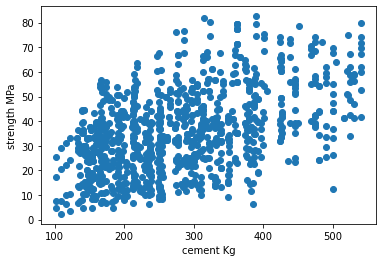

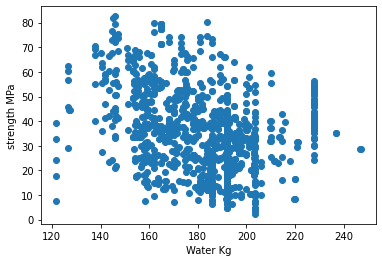

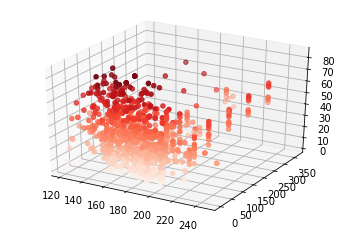

In [77]:
#create more easily accessible dictionaries for data parsing
features = {}
zfeatures = {}
cement = []
for i in range(1, sheet.nrows): 
    cement.append(sheet.cell_value(i, 0)) 
features['cement'] = cement 
zfeatures['cement'] = cement 
slag = []
for i in range(1, sheet.nrows): 
    slag.append(sheet.cell_value(i, 1)) 
features['slag'] = slag
zfeatures['slag'] = slag
ash = []
for i in range(1, sheet.nrows): 
    ash.append(sheet.cell_value(i, 2)) 
features['ash'] = ash
zfeatures['ash'] = ash
water = []
for i in range(1, sheet.nrows): 
    water.append(sheet.cell_value(i, 3)) 
features['water'] = water
zfeatures['water'] = water
plastic = []
for i in range(1, sheet.nrows): 
    plastic.append(sheet.cell_value(i, 4)) 
features['plastic'] = plastic
zfeatures['plastic'] = plastic
coarse = []
for i in range(1, sheet.nrows): 
    coarse.append(sheet.cell_value(i, 5)) 
features['coarse'] = coarse
zfeatures['coarse'] = coarse
fine = []
for i in range(1, sheet.nrows): 
    fine.append(sheet.cell_value(i, 6)) 
features['fine'] = fine
zfeatures['fine'] = fine
age = []
for i in range(1, sheet.nrows): 
    age.append(sheet.cell_value(i, 7)) 
features['age'] = age
zfeatures['age'] = age
strength = []
for i in range(1, sheet.nrows): 
    strength.append(sheet.cell_value(i, 8)) 
features['strength'] = strength
zfeatures['strength'] = strength

fig, ax = plt.subplots()
ax.scatter(cement, strength)
ax.set_xlabel('cement Kg')
ax.set_ylabel('strength MPa')
fig, ax = plt.subplots()
ax.scatter(water, strength)
ax.set_xlabel('Water Kg')
ax.set_ylabel('strength MPa')
fig, ax = plt.subplots()
ax.scatter(age, strength)
ax.set_xlabel('age days')
ax.set_ylabel('strength MPa')
ax = plt.axes(projection='3d')
ax.scatter3D(water, age, strength, c=strength, cmap='Reds')


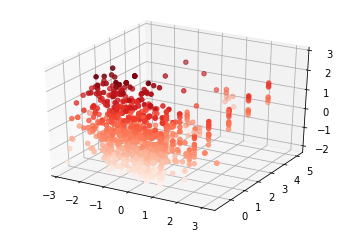

In [78]:
#Normalize the scores by zscore
import statistics

for x in features:
    mean = statistics.mean(features[x])
    sd = statistics.stdev(features[x])
    count = 0
    for i in features[x]:
        z = (i - mean)/ sd
        zfeatures[x][count] = z
        count += 1

ax = plt.axes(projection='3d')
ax.scatter3D(zfeatures['water'], zfeatures['age'], zfeatures['strength'], c=zfeatures['strength'], cmap='Reds')

In [79]:
#find the highest correlative data
corel = pd.DataFrame.from_dict(features)
corel.corr(method='kendall')

,cement,slag,ash,water,plastic,coarse,fine,age,strength
cement,1.000000,-0.171954,-0.329264,-0.064505,0.028515,-0.103292,-0.119113,0.003560,0.327138
slag,-0.171954,1.000000,-0.197647,0.032840,0.074298,-0.246352,-0.214546,-0.014619,0.118005
ash,-0.329264,-0.197647,1.000000,-0.209947,0.350130,0.056470,0.044874,0.002030,-0.059708
water,-0.064505,0.032840,-0.209947,1.000000,-0.528651,-0.149510,-0.244550,0.062910,-0.206010
plastic,0.028515,0.074298,0.350130,-0.528651,1.000000,-0.138178,0.119914,-0.006142,0.249057
coarse,-0.103292,-0.246352,0.056470,-0.149510,-0.138178,1.000000,-0.053946,-0.031479,-0.123722
fine,-0.119113,-0.214546,0.044874,-0.244550,0.119914,-0.053946,1.000000,-0.041849,-0.122260
age,0.003560,-0.014619,0.002030,0.062910,-0.006142,-0.031479,-0.041849,1.000000,0.449016
strength,0.327138,0.118005,-0.059708,-0.206010,0.249057,-0.123722,-0.122260,0.449016,1.000000


In [85]:
classifier = GaussianProcessClassifier(RBF(1.0))

In [114]:
features1 = []
xlist = zfeatures['age']
features1.append(xlist)
features1.append(zfeatures['plastic'])
features1.append(zfeatures['cement'])
unlabeled = []
trainingfeatures = []
for x in range(sheet.nrows-1):
    if x < 399:
        holder1 =[]
        holder1.append(zfeatures['age'][x])
        holder1.append(zfeatures['plastic'][x])
        holder1.append(zfeatures['cement'][x])
        trainingfeatures.append(holder1)
    else:
        holder = []
        holder.append(zfeatures['age'][x])
        holder.append(zfeatures['plastic'][x])
        holder.append(zfeatures['cement'][x])
        unlabeled.append(holder)
for x in range(len(zfeatures['strength'])):
    zfeatures['strength'][x] = int(x)
trainingstrength = []
for x in range(399):
    trainingstrength.append(zfeatures['strength'][x]) 
print(len(trainingfeatures))
print(len(trainingstrength))
classifier.fit(trainingfeatures, trainingstrength)

399
399


GaussianProcessClassifier(copy_X_train=True, kernel=RBF(length_scale=1),
                          max_iter_predict=100, multi_class='one_vs_rest',
                          n_jobs=None, n_restarts_optimizer=0,
                          optimizer='fmin_l_bfgs_b', random_state=None,
                          warm_start=False)

In [117]:
#define problem
problem = {
    'points': features2,
    'num_classes': 2,
    'batch_size': 8,
    'num_queries': len(features2),
    'model': classifier
}

In [129]:
for x in range(len(unlabeled)):
    for y in range(len(unlabeled[1])):
        unlabeled[x][y] = int(unlabeled[x][y])
unlabeled1 = np.array(unlabeled)
random_ixs = random_sampling(problem, trainingfeatures, trainingstrength, unlabeled1, problem['batch_size'])

In [130]:
greedy_ixs = greedy(problem, trainingfeatures, trainingstrength, unlabeled1, problem['batch_size'])

TypeError: only integer scalar arrays can be converted to a scalar index